의사결정나무는 어떻게 학습모델이 데이터를 분류해나가는지에 대한 로직을 rule 기반으로 보여주면서 사람이 이해할 수 있는 매커니즘을 제공해준다. Data driven 된 방식을 decision subsystem


의사결정나무의 root node로부터 계속 확장해 나가다 보면 leaf 노드에서 실제 의미있는 분류체계를 알 수 있다.


# 필수 라이브러리

In [2]:
pip install graphviz

  Using cached graphviz-0.20-py3-none-any.whl (46 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# 라이브러리 로드
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # 학습, 테스트set 구분
from sklearn.tree import export_graphviz # tree 시각화를 위해
# export_graphviz : 의사결정나무에 대한 graphviz dot data 생성하는 함수
import graphviz # tree 시각화
import sklearn.metrics as mt # 성능지표를 계산하기 위해 import
from sklearn.model_selection import cross_val_score, cross_validate # 교차검증

import warnings
warnings.filterwarnings('ignore')

# 1) 데이터 셋 소개 

In [5]:
import warnings; warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('1year.csv')
# df1 = df1.replace({'bankruptcy':0},-2)
df1 = df1.replace({'bankruptcy':1},1)

df2 = pd.read_csv('2year.csv')
# df2 = df2.replace({'bankruptcy':0},-2)
df2 = df2.replace({'bankruptcy':1},2)

df3 = pd.read_csv('3year.csv')
# df3 = df3.replace({'bankruptcy':0},-3)
df3 = df3.replace({'bankruptcy':1},3)

df4 = pd.read_csv('4year.csv')
# df4 = df4.replace({'bankruptcy':0},-4)
df4 = df4.replace({'bankruptcy':1},4)

df5 = pd.read_csv('5year.csv')
# df5 = df5.replace({'bankruptcy':0},-5)
df5 = df5.replace({'bankruptcy':1},5)

df = pd.concat([df1, df2, df3, df4, df5])

In [4]:
df = pd.read_csv('obesity.csv')
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,2,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,3,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,4,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,5,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [1093]:
# id 컬럼 제거 / 결측치 확인
df.drop('id', axis=1, inplace=True)
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [1094]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [1095]:
print("데이터 셋의 관측치 수와 Class 수는 아래와 같다.")
print("Bank :",np.shape(df)[0],"/ Class : ", df['NObeyesdad'].nunique())

데이터 셋의 관측치 수와 Class 수는 아래와 같다.
Bank : 2111 / Class :  7


# 2) 전처리

## 2-1) Decision Tree 실습을 위한 종속 변수 처리

In [1096]:
# 종속 변수의 class
df['NObeyesdad'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [1097]:
# obesity / non-obesity 로 분류
df['NObeyesdad'] = df['NObeyesdad'].replace({'Normal_Weight': 'Non-Obesity'})
df['NObeyesdad'] = df['NObeyesdad'].replace({'Overweight_Level_I': 'Non-Obesity'})
df['NObeyesdad'] = df['NObeyesdad'].replace({'Overweight_Level_II': 'Non-Obesity'})
df['NObeyesdad'] = df['NObeyesdad'].replace({'Insufficient_Weight': 'Non-Obesity'})


df['NObeyesdad'] = df['NObeyesdad'].replace({'Obesity_Type_I': 'Obesity'})
df['NObeyesdad'] = df['NObeyesdad'].replace({'Obesity_Type_II': 'Obesity'})
df['NObeyesdad'] = df['NObeyesdad'].replace({'Obesity_Type_III': 'Obesity'})

df.rename(columns={'NObeyesdad' : 'class'},inplace=True)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,class
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Non-Obesity
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Non-Obesity
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Non-Obesity
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Non-Obesity
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Non-Obesity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity


##  2-2) 범주형 변수에 대한 처리

In [1098]:
# 범주형 변수의 처리를 위해 feature의 type 확인
categorical = df.select_dtypes('object')
print(categorical.columns.to_list())
print('\n범주형 변수 각각의 고유한 값의 개수는 아래와 같습니다.\n')

for col_name in categorical:
    print(col_name, ':', categorical[col_name].nunique())

['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'class']

범주형 변수 각각의 고유한 값의 개수는 아래와 같습니다.

Gender : 2
family_history_with_overweight : 2
FAVC : 2
CAEC : 4
SMOKE : 2
SCC : 2
CALC : 4
MTRANS : 5
class : 2


In [1099]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df['Gender'].values)
df['family_history_with_overweight'] = encoder.fit_transform(df['family_history_with_overweight'].values)
df['FAVC'] = encoder.fit_transform(df['FAVC'].values)
df['SMOKE'] = encoder.fit_transform(df['SMOKE'].values)
df['SCC'] = encoder.fit_transform(df['SCC'].values)
df['class'] = encoder.fit_transform(df['class'].values)
df.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,class
0,0,21.0,1.62,64.0,1,0,2.0,3.0,Sometimes,0,2.0,0,0.0,1.0,no,Public_Transportation,0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,Sometimes,1,3.0,1,3.0,0.0,Sometimes,Public_Transportation,0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,Sometimes,0,2.0,0,2.0,1.0,Frequently,Public_Transportation,0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,Sometimes,0,2.0,0,2.0,0.0,Frequently,Walking,0
4,1,22.0,1.78,89.8,0,0,2.0,1.0,Sometimes,0,2.0,0,0.0,0.0,Sometimes,Public_Transportation,0


In [1100]:
# 나머지 독립 변수에 대하여 One-Hot Encoding
df = pd.get_dummies(df)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,CAEC_no,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,21.0,1.62,64.0,1,0,2.0,3.0,0,2.0,...,0,0,0,0,1,0,0,0,1,0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,3.0,...,0,0,0,1,0,0,0,0,1,0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,0,2.0,...,0,0,1,0,0,0,0,0,1,0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,0,2.0,...,0,0,1,0,0,0,0,0,0,1
4,1,22.0,1.78,89.8,0,0,2.0,1.0,0,2.0,...,0,0,0,1,0,0,0,0,1,0


## 2-3) 이상치 랜덤하게 생성

In [1101]:
y_df = df['class']
y_df = y_df.to_frame()
df.drop('class', axis=1, inplace=True)

In [1102]:
outlier = 10000000

In [1103]:
df.count().sum() * 0.03

1646.58

In [1104]:
import random

for i in range(1647):
    r = random.randrange(0, 2111)
    c = random.randrange(0, 25)
    df.iloc[r,c] =  outlier

In [1105]:
df = pd.concat([df, y_df],axis=1)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,class
0,0,21.0,1.62,64.0,1,0,2.0,3.0,0,2.0,...,0,0,0,1,0,0,0,1,0,0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,3.0,...,0,0,1,0,0,0,0,1,0,0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,0,10000000.0,...,0,1,0,0,0,0,0,1,0,0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,0,2.0,...,0,1,0,0,0,0,0,0,1,0
4,1,22.0,1.78,89.8,0,0,2.0,1.0,0,2.0,...,0,0,1,0,0,0,0,1,0,0


##  2-4) 성능 평가를 위한 Dataset Split

In [1106]:
x_train, x_test, y_train, y_test = train_test_split(df, df['class'], test_size=0.3, random_state=1024)# y_train = y_train.astype({'y':'int'})  # 형 변환 필요
x_train = x_train.drop(['class'], axis=1)
x_test = x_test.drop(['class'], axis=1)
y_train = y_train.to_frame()
y_test = y_test.to_frame()

# 3) Decision Tree

## 3-1) Decision Tree 성능평가를 위한 함수 구현

In [1107]:
def print_pred_result(y_test, y_pred):
    accuracy = mt.accuracy_score(y_test, y_pred)
    recall = mt.recall_score(y_test, y_pred)
    precision = mt.precision_score(y_test, y_pred)
    f1_score = mt.f1_score(y_test, y_pred)
    matrix = mt.confusion_matrix(y_test, y_pred)
    
    print('Accuracy: ', format(accuracy,'.2f'),'\n')  # train 데이터에 대해서 과적합시켰기 때문
    print('Recall: ', format(recall,'.2f'),'\n')  # 실제 양성인 사람 중 몇명을 맞췄는지
    print('Precision: ', format(precision,'.2f'),'\n')  # 양성이라고 예측을 한 사람중 몇명이 진짜 양성인지
    print('F1_score: ', format(f1_score,'.2f'),'\n') 
    print('Confusion Matrix:','\n', matrix)
    

## 3-2) Training

In [1108]:
dt_clf = DecisionTreeClassifier(random_state=5764)
dt_clf.fit(x_train, y_train)

DecisionTreeClassifier(random_state=5764)

## 3-3) Graphviz -> Tree 가시화

In [1109]:
export_graphviz(dt_clf, out_file="tree.dot", class_names = ['1', '0'], feature_names = x_train.columns, impurity=True, filled=True)

[ max_depth의 제약이 없는 경우의 Decision Tree 시각화 ]


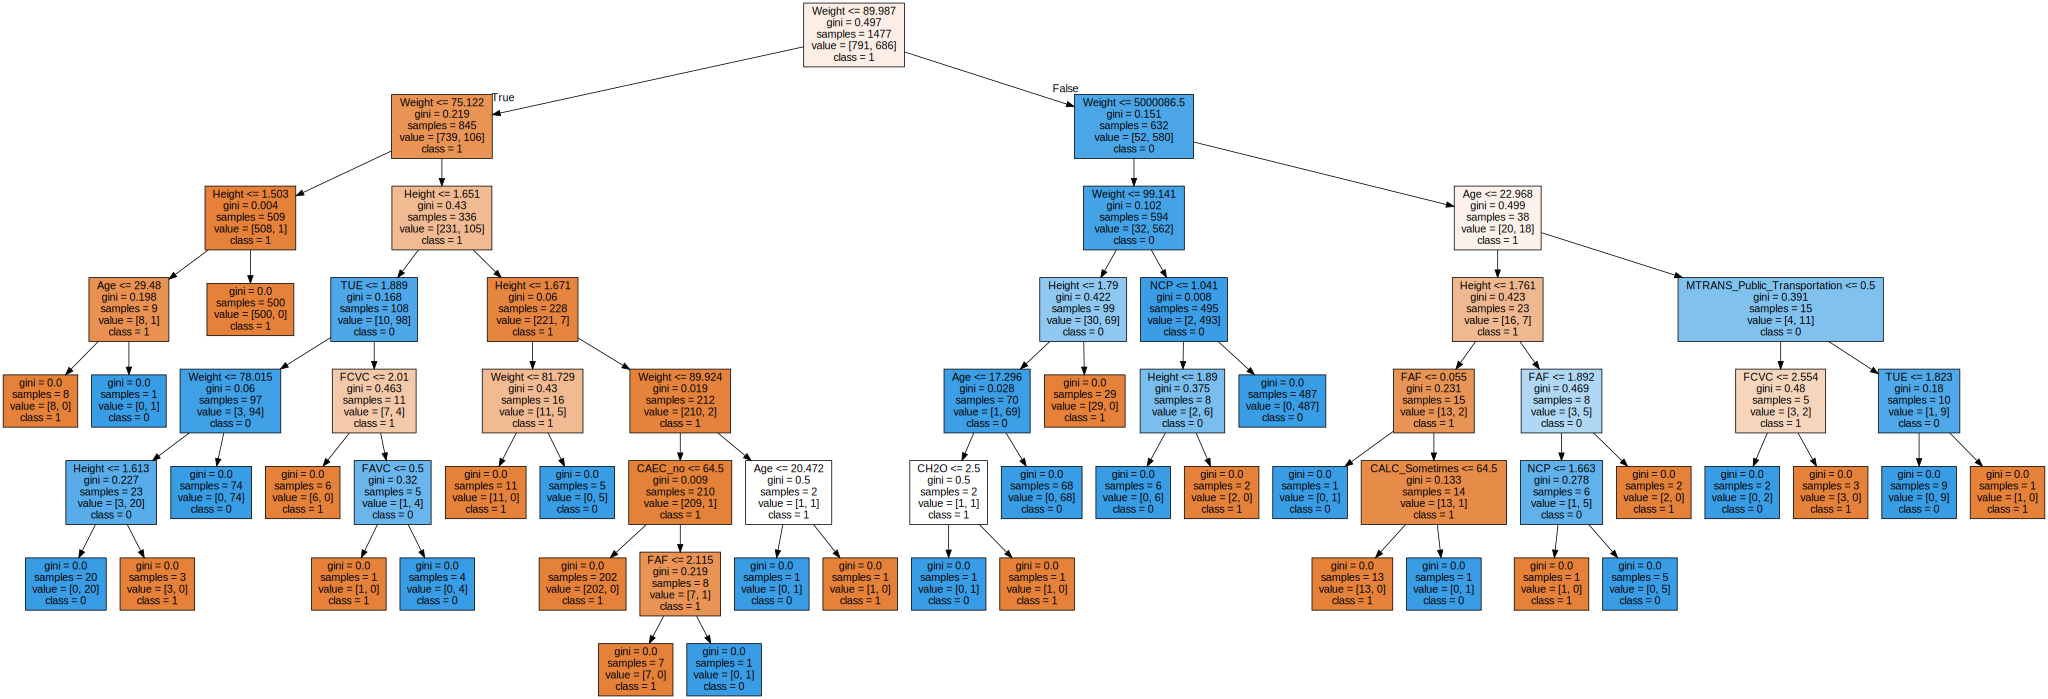

In [1110]:
import graphviz
print('[ max_depth의 제약이 없는 경우의 Decision Tree 시각화 ]')
# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## 4-1) Scoring and Confusion Matrix

In [1111]:
# 학습결과 평가
y_pred = dt_clf.predict(x_test) 
print("Train_Accuracy : ", dt_clf.score(x_train, y_train), '\n')
print("Test_Accuracy : ", dt_clf.score(x_test, y_test), '\n')

print_pred_result(y_test, y_pred)

Train_Accuracy :  1.0 

Test_Accuracy :  0.9684542586750788 

Accuracy:  0.97 

Recall:  0.97 

Precision:  0.97 

F1_score:  0.97 

Confusion Matrix: 
 [[338  10]
 [ 10 276]]


## 5) Grid Search with Cross Validation

## 5-1) Grid Search 수행

In [1112]:
from sklearn.model_selection import GridSearchCV
dt_clf2 = DecisionTreeClassifier(random_state=5)
parameters = {'splitter': ['best', 'random'],
             'max_depth': [4, 5, 6, 8, 10],
             'min_samples_split': [2, 3, 5]}

dt_grid = GridSearchCV(dt_clf2, param_grid = parameters, cv = 5)

dt_grid.fit(x_train, y_train)

result = pd.DataFrame(dt_grid.cv_results_['params'])
result['mean_test_score'] = dt_grid.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,max_depth,min_samples_split,splitter,mean_test_score
12,6,2,best,0.973585
28,10,5,best,0.971551
22,8,5,best,0.971551
18,8,2,best,0.970875
24,10,2,best,0.970875
16,6,5,best,0.969519
20,8,3,best,0.969519
14,6,3,best,0.969519
26,10,3,best,0.969519
10,5,5,best,0.968841


## 5-2) 하이퍼 파라미터 튜닝으로 Decsion Tree 구축

In [1113]:
# 학습결과 평가
dt_grid = DecisionTreeClassifier(random_state=2, splitter='best', max_depth=6, min_samples_split=2)
dt_grid.fit(x_train, y_train)
y_pred = dt_grid.predict(x_test)

print("Train_Accuracy : ", dt_grid.score(x_train, y_train), '\n')
print("Test_Accuracy : ", dt_grid.score(x_test, y_test), '\n')

print_pred_result(y_test, y_pred)

Train_Accuracy :  0.999322951929587 

Test_Accuracy :  0.9652996845425867 

Accuracy:  0.97 

Recall:  0.97 

Precision:  0.96 

F1_score:  0.96 

Confusion Matrix: 
 [[336  12]
 [ 10 276]]


# 6) 가지치기 수행 (Pruning phase)

## 6-1) max_depth = 2

In [1114]:
pruned_dt_clf = DecisionTreeClassifier(random_state=2022, max_depth=2) # max_depth=3으로 제한
pruned_dt_clf .fit(x_train, y_train)

print("Accuracy of training set: {:.3f}".format(pruned_dt_clf.score(x_train, y_train)))
print("Accuracy of test set: {:.3f}".format(pruned_dt_clf.score(x_test, y_test)))

Accuracy of training set: 0.894
Accuracy of test set: 0.899


In [1045]:
# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(pruned_dt_clf, out_file="prunedtree.dot", class_names = ['0','1'], feature_names = x_train.columns, impurity=True, filled=True)

[ max_depth가 2인 경우의 Decision Tree 시각화 ]


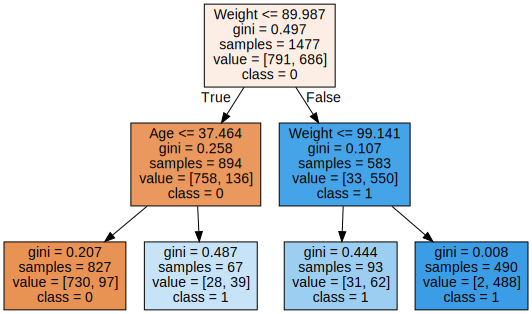

In [1046]:
print('[ max_depth가 2인 경우의 Decision Tree 시각화 ]')
# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("prunedtree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [1047]:
# 학습결과 평가
y_pred = pruned_dt_clf.predict(x_test) 
print("Train_Accuracy : ", pruned_dt_clf.score(x_train, y_train), '\n')  # train 에 과적합 시켰으니깐.
print("Test_Accuracy : ", pruned_dt_clf.score(x_test, y_test), '\n')

print_pred_result(y_test, y_pred)

Train_Accuracy :  0.8930264048747462 

Test_Accuracy :  0.8738170347003155 

Accuracy:  0.87 

Recall:  0.84 

Precision:  0.87 

F1_score:  0.86 

Confusion Matrix: 
 [[313  35]
 [ 45 241]]


## 6-2) max_depth = 3

In [1048]:
pruned_dt_clf = DecisionTreeClassifier(random_state=2022, max_depth=3) # max_depth=3으로 제한
pruned_dt_clf .fit(x_train, y_train)

print("Accuracy of training set: {:.3f}".format(pruned_dt_clf.score(x_train, y_train)))
print("Accuracy of test set: {:.3f}".format(pruned_dt_clf.score(x_test, y_test)))

Accuracy of training set: 0.922
Accuracy of test set: 0.902


In [1049]:
# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(pruned_dt_clf, out_file="prunedtree.dot", class_names = ['0','1'], feature_names = x_train.columns, impurity=True, filled=True)

[ max_depth가 3인 경우의 Decision Tree 시각화 ]


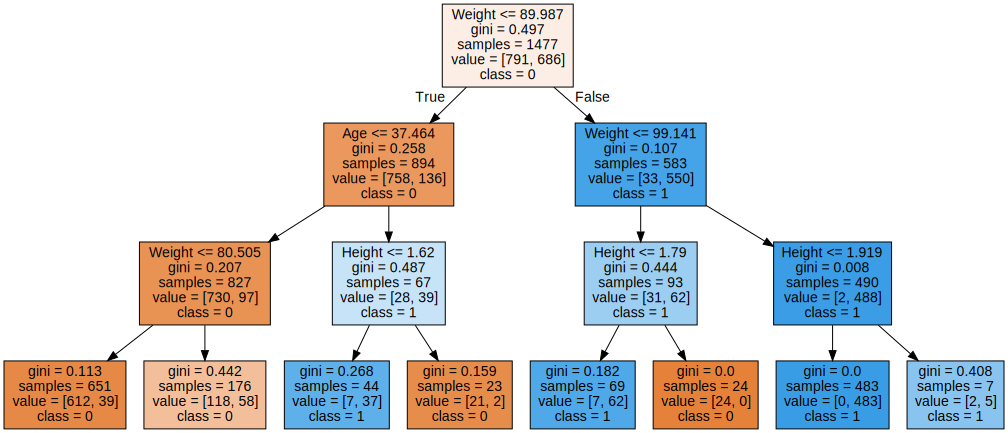

In [1050]:
print('[ max_depth가 3인 경우의 Decision Tree 시각화 ]')
# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("prunedtree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [1051]:
# 학습결과 평가
y_pred = pruned_dt_clf.predict(x_test) 
print("Train_Accuracy : ", pruned_dt_clf.score(x_train, y_train), '\n')  # train 에 과적합 시켰으니깐.
print("Test_Accuracy : ", pruned_dt_clf.score(x_test, y_test), '\n')

print_pred_result(y_test, y_pred)

Train_Accuracy :  0.9221394719025051 

Test_Accuracy :  0.9022082018927445 

Accuracy:  0.90 

Recall:  0.83 

Precision:  0.95 

F1_score:  0.88 

Confusion Matrix: 
 [[335  13]
 [ 49 237]]
